---
title: Saint Michael Sword
subtitle: Are the 7 famous Cathedrals really on a straight line? A numerical investigation
date: 2024-04-20
categories: [tutorial, geospatial]
image: images/cover.png
toc: true
draft: false
colab: <a href="https://colab.research.google.com/github/SebastianoF/GeoDsBlog/blob/master/posts/gds-2024-04-20-cathedrals/index.ipynb" target="_blank"><img src="images/colab.svg"></a>
github: <a href="https://github.com/SebastianoF/GeoDsBlog/blob/master/posts/gds-2024-04-20-cathedrals/index.ipynb" target="_blank">  <img src="images/github.svg"> </a>
twitter-card:
  image: images/cover.png
---

![](images/cover.png)


## Introduction

We [read on wikipedia](https://en.wikipedia.org/wiki/Saint_Michael%27s_line#:~:text=The%20aligned%20sites%20are%20almost,Stella%20Maris%20Monastery%3B%20although%20the) that there are 7 famous Cathedrals built across the past centuries, all related to Saint Michael and all aligned on a straight line.

Being more like Saint Thomas than Saint Michael, we say that if we do not see we do not believe.

So we consider the perfect alignment as our research hypothesis, and we proceed as follows:

1. Collect the dataset of the cathedrals via manual segmentation of the map.
2. Compute the geodesic line (on a spherical model of the earth) between the first and the last cathedral.
    - draw a geodesic line on the surface of a sphere.
3. Compute the distance between the cathedrals and the geodesic line connecting the first and the last one.
    - compute the distance between a point and a line on the sphere.

This methodology has a couple of flaws: 

- The spherical model is an approximation of the surface of the earth.
- The line is between the first and the last cathedrals as ground truth would bias the result for towards the misalignment of these two. A single line that minimizes the distances between all the cathedrals would reduce the overall error.

We start the analysis nonetheless with these two limitations in mind and we see what happens, before deciding where to go next.


## Dataset collection


In [30]:
from shapely.geometry import shape
import pandas as pd
import numpy as np
import geopandas as gpd
from IPython.display import Image

from copy import deepcopy
from keplergl import KeplerGl


KEPLER_OUTPUT = False  # set to False to see the kepler maps interactively
OVERWRITE_CONFIGS = False

In [31]:

# Get coordinates from google maps, and teh segmentations from KepelerGl.

columns = ["name", "longitude", "latitude", "geometry"]

geometry_skellig = {
    "type": "Polygon",
    "coordinates": [
        [
            [-10.538210287997396, 51.772185270560065],
            [-10.538373297938953, 51.7721348360848],
            [-10.538348846448207, 51.77204909734886],
            [-10.53876452179865, 51.77191796720246],
            [-10.53873191981036, 51.771827184569275],
            [-10.539261702118932, 51.77147918278735],
            [-10.539147595159863, 51.771378312203616],
            [-10.538894929750949, 51.77155483557632],
            [-10.538577060365403, 51.77169605377814],
            [-10.538422200921415, 51.77178683667508],
            [-10.538226588991567, 51.77183727153805],
            [-10.537973923582655, 51.77189274982316],
            [-10.538055428553408, 51.77197344538836],
            [-10.53818583650665, 51.77195327151059],
            [-10.538226588991567, 51.77205414080813],
            [-10.538210287997396, 51.772185270560065],
        ]
    ],
}

geometry_st_michael_mount = {
    "type": "Polygon",
    "coordinates": [
        [
            [-5.477544937910665, 50.116733166283005],
            [-5.477912989731039, 50.11667316516922],
            [-5.4779504187298205, 50.11671316592009],
            [-5.478093896558475, 50.1166931655488],
            [-5.4781438018902, 50.11676516684632],
            [-5.478461948378875, 50.116701165698345],
            [-5.478349661383472, 50.116313156907054],
            [-5.47812508739081, 50.116349157855076],
            [-5.4780876583920275, 50.11629315636868],
            [-5.47783189356703, 50.11633715754206],
            [-5.477594843242365, 50.11637315847207],
            [-5.477519985244801, 50.11645716053674],
            [-5.477563652410055, 50.11652916218916],
            [-5.4777008920712955, 50.11652516210019],
            [-5.4777008920712955, 50.11658116331525],
            [-5.477507508911883, 50.11666116493737],
            [-5.477544937910665, 50.116733166283005],
        ]
    ],
}

geometry_mont_st_michel = {
    "type": "Polygon",
    "coordinates": [
        [
            [-1.5118395414485475, 48.636192167017676],
            [-1.5119505023709103, 48.63616378229307],
            [-1.5119182879097475, 48.63610701279718],
            [-1.5122440119059872, 48.636014762229614],
            [-1.512172424213728, 48.63592014608774],
            [-1.512283385136142, 48.635884664988474],
            [-1.5122547500594112, 48.635790048602615],
            [-1.5121437891370484, 48.63577585612979],
            [-1.5119612405243346, 48.63579951024894],
            [-1.511907549755382, 48.63573564410058],
            [-1.511710683603845, 48.63578295236671],
            [-1.5116820485271396, 48.63575220199832],
            [-1.5115782463746592, 48.63577585612979],
            [-1.5113527451473583, 48.6357971448375],
            [-1.511259681148302, 48.63582552976841],
            [-1.5111379820725148, 48.63588703039579],
            [-1.5110592356123072, 48.63593197311487],
            [-1.5109983860744136, 48.636005300623694],
            [-1.5109697509977082, 48.636052608636966],
            [-1.5107728848461712, 48.63604787783775],
            [-1.5107514085383815, 48.63614012834475],
            [-1.5109804891510816, 48.63616851308267],
            [-1.5110449180734582, 48.63622055172633],
            [-1.5110735531501636, 48.63624893641774],
            [-1.511381380223122, 48.63627022492708],
            [-1.511703524834904, 48.63621818633469],
            [-1.5118395414485475, 48.636192167017676],
        ]
    ],
}


geometry_san_michele_sacra = {
    "type": "Polygon",
    "coordinates": [
        [
            [7.342461396228171, 45.09750192282457],
            [7.342770176683438, 45.09750192282457],
            [7.342788077000524, 45.09747033312251],
            [7.343105807613863, 45.09751455870019],
            [7.343092382376297, 45.097568261140914],
            [7.343101332534344, 45.0976409173037],
            [7.343195309195373, 45.09771041441673],
            [7.343275860617843, 45.097903110514835],
            [7.343249010143678, 45.09802315037865],
            [7.343105807613863, 45.098209527560805],
            [7.3428283527112885, 45.09831693108512],
            [7.342761226525392, 45.098449605747064],
            [7.342967080162602, 45.09850330730838],
            [7.342935754608892, 45.09857596228209],
            [7.342738851130772, 45.09854121426282],
            [7.342644874469717, 45.09856016773029],
            [7.342389794963722, 45.098522260789075],
            [7.342327143856378, 45.098465400329424],
            [7.342488246703278, 45.098152666790355],
            [7.342474821465712, 45.09808001127805],
            [7.3423674195681095, 45.09802315037865],
            [7.342447970991547, 45.09787152103536],
            [7.34249719686135, 45.097843090488624],
            [7.342461396228171, 45.09750192282457],
        ]
    ],
}

geometry_santuario_san_michele = {
    "type": "Polygon",
    "coordinates": [
        [
            [15.954708098648354, 41.70774624650484],
            [15.95484520240551, 41.70774624650484],
            [15.955046626444242, 41.70771718285521],
            [15.955126180475807, 41.70770581011917],
            [15.955176959645415, 41.707803110128424],
            [15.955139721587672, 41.70782332829385],
            [15.955200656591268, 41.70789156455518],
            [15.955099098251925, 41.70803182775236],
            [15.954960301855804, 41.708189781437795],
            [15.954833353932584, 41.70818346329781],
            [15.954792730596836, 41.70815313621718],
            [15.954733488233222, 41.7080886911241],
            [15.95464377836678, 41.708063418520645],
            [15.954615003503958, 41.707964855273005],
            [15.954615003503958, 41.70788524638588],
            [15.954652241561726, 41.70787766458189],
            [15.954708098648354, 41.70774624650484],
        ]
    ],
}

geometry_taxiarchi_michail = {
    "type": "Polygon",
    "coordinates": [
        [
            [27.84592051904731, 36.54830393321039],
            [27.846087201698992, 36.54836364773902],
            [27.846075939357537, 36.548390790691705],
            [27.84614801834191, 36.548419743163294],
            [27.846159280683366, 36.548396219281116],
            [27.846316953461884, 36.54846136232331],
            [27.84629668124823, 36.548499362405614],
            [27.846456606495014, 36.54855907678405],
            [27.846648066297924, 36.548256885367536],
            [27.846251631882385, 36.54808859861725],
            [27.846256136818965, 36.54806869370842],
            [27.84619306770776, 36.548050598332246],
            [27.846186310302834, 36.54806145555846],
            [27.846042152333148, 36.548008978951856],
            [27.846019627651152, 36.548050598332246],
            [27.846033142459984, 36.54805783648323],
            [27.846003860373138, 36.5481211702745],
            [27.84592051904731, 36.54830393321039],
        ]
    ],
}

geometry_stella_maris_monastery = {
    "type": "Polygon",
    "coordinates": [
        [
            [34.96991480318133, 32.8276822842215],
            [34.96962584007829, 32.8271624051118],
            [34.97034454318042, 32.826841759593194],
            [34.97061868766258, 32.827420788523035],
            [34.96991480318133, 32.8276822842215],
        ]
    ],
}


From the manual segmentations above, and the visually estimated locations of the tower bells in latitude, and longitude we create a 7 rows geopandas dataframe.

In [32]:
landmarks_michael = {
    1: ["Skellig Michael", -10.538483, 51.772035, shape(geometry_skellig)],
    2: ["St Michael's Mount",  -5.477813, 50.116531, shape(geometry_st_michael_mount)],
    3: ["Mont Saint-Michel", -1.511447, 48.636038, shape(geometry_mont_st_michel)],
    4: ["Sacra di San Michele", 7.342842, 45.098029, shape(geometry_san_michele_sacra)],
    5: ["San Michele Arcangelo", 15.954767, 41.707770, shape(geometry_santuario_san_michele)],
    6: ["Taxiarchi Michail", 27.846123,36.548389, shape(geometry_taxiarchi_michail)],
    7: ["Stella Maris", 34.969960, 32.827297, shape(geometry_stella_maris_monastery)],
}

In [33]:
gdf_cathedrals = gpd.GeoDataFrame(pd.DataFrame(landmarks_michael, index = ["name", "longitude", "latitude", "geometry"]).T)
gdf_cathedrals

,name,longitude,latitude,geometry
1,Skellig Michael,-10.538483,51.772035,"POLYGON ((-10.53821 51.77219, -10.53837 51.772..."
2,St Michael's Mount,-5.477813,50.116531,"POLYGON ((-5.47754 50.11673, -5.47791 50.11667..."
3,Mont Saint-Michel,-1.511447,48.636038,"POLYGON ((-1.51184 48.63619, -1.51195 48.63616..."
4,Sacra di San Michele,7.342842,45.098029,"POLYGON ((7.34246 45.09750, 7.34277 45.09750, ..."
5,San Michele Arcangelo,15.954767,41.70777,"POLYGON ((15.95471 41.70775, 15.95485 41.70775..."
6,Taxiarchi Michail,27.846123,36.548389,"POLYGON ((27.84592 36.54830, 27.84609 36.54836..."
7,Stella Maris,34.96996,32.827297,"POLYGON ((34.96991 32.82768, 34.96963 32.82716..."


### Visualise the dataset on a kepler map

In [34]:
# Simple utils to save and load Kepler configurations
from pathlib import PosixPath, Path
import json


class KeplerConfigManager:
    """Save, load and list config files for KeplerGl""" 
    
    def __init__(self, path_to_folder: PosixPath = Path().cwd() / "kepler_configs"):
        self.path_to_folder = path_to_folder
    
    @staticmethod
    def _check_name(name_config: str):
        if name_config.endswith(".json"):
            raise ValueError("Name of the config must not include the extension '.json' .")
        
    def _parse_name(self, name_config: str) -> PosixPath:
        return self.path_to_folder / (name_config + ".json")

    def list_available_configs(self):
        return [f.stem for f in self.path_to_folder.glob("*.json")]
        

    def save_config(self, k_map: KeplerGl, name_config: str):
        self._check_name(name_config)
        with self._parse_name(name_config).open("w+", encoding="UTF-8") as file_target: 
            json.dump(k_map.config, file_target, indent=4)
        
    
    def load_config(self, name_config: str):
        self._check_name(name_config)
        return json.loads(self._parse_name(name_config).read_text(encoding="UTF-8"))


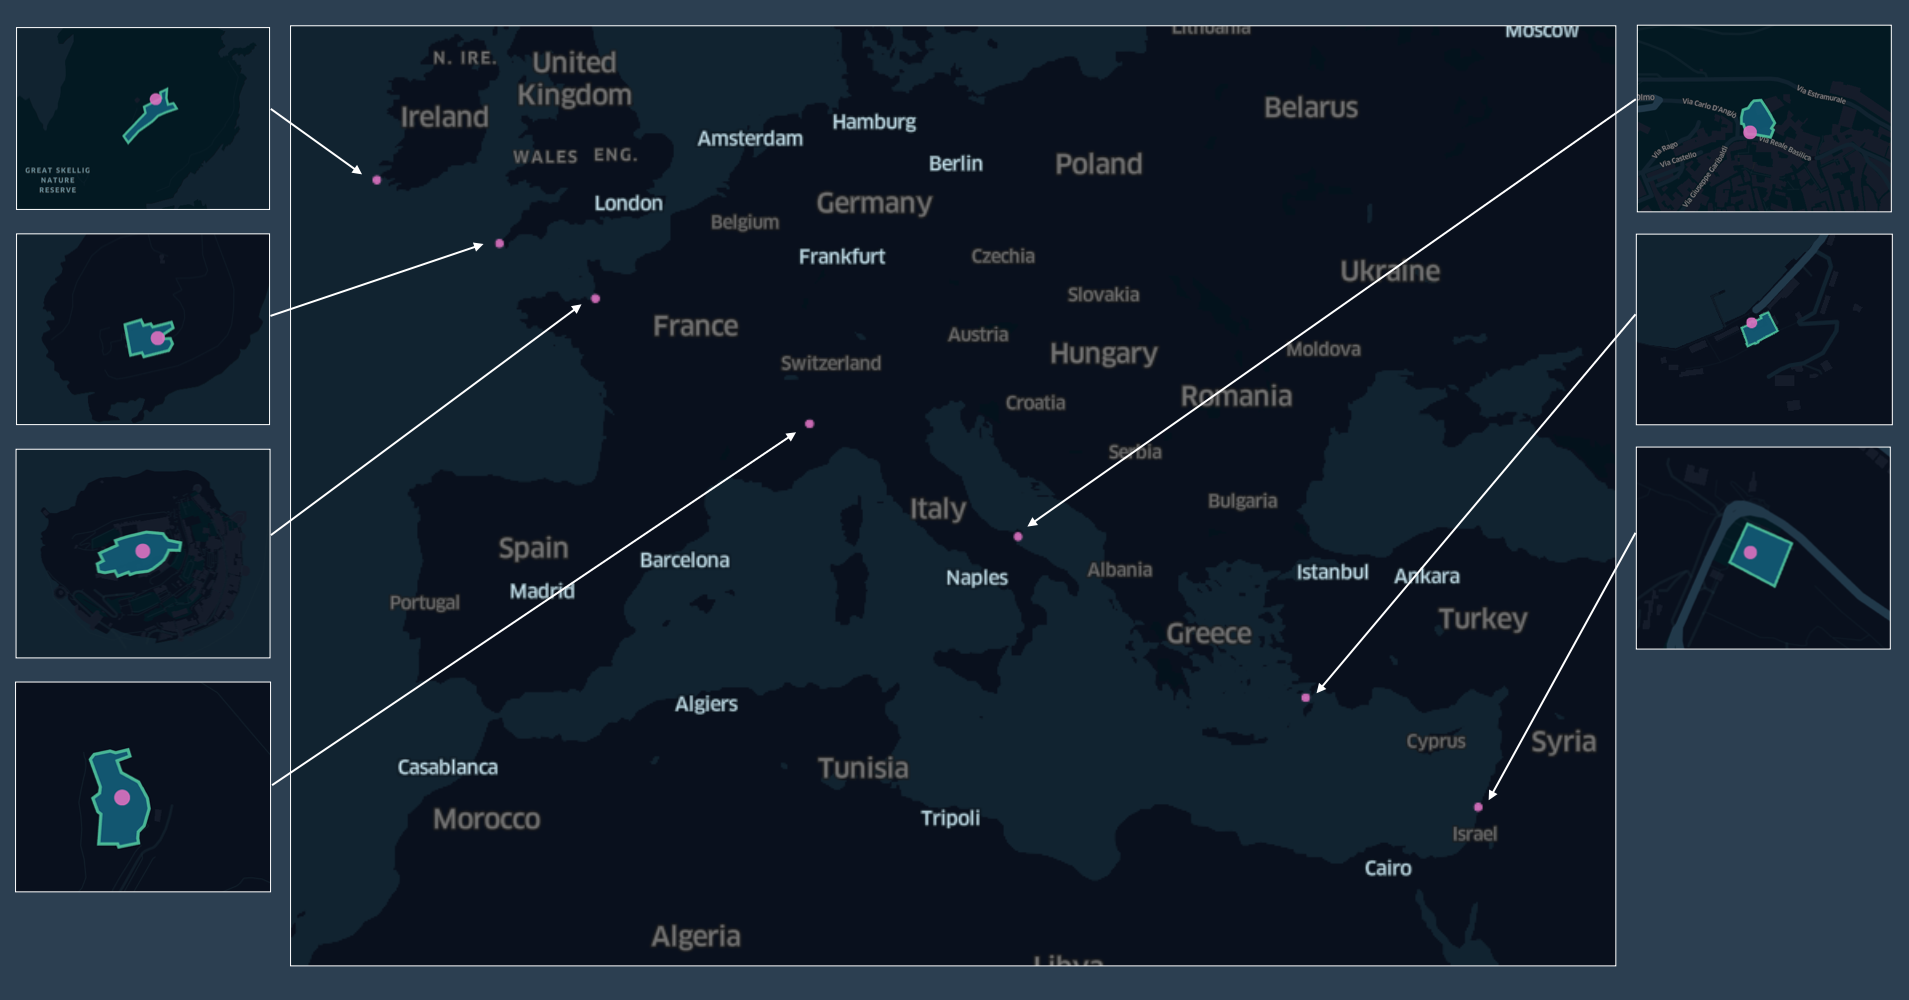

In [35]:
kepler_data = deepcopy({"cathedrals": gdf_cathedrals.__geo_interface__})


if KEPLER_OUTPUT:
    kcm = KeplerConfigManager()
    config_map_1 = kcm.load_config("configs_map_1")
    
    kmap_1 = KeplerGl(
        data=kepler_data,
        height=800,
        config=config_map_1,
    )
    display(kmap_1)
else:
    display(Image("images/cathedrals_in_a_row.png"))



In [36]:
if KEPLER_OUTPUT and OVERWRITE_CONFIGS:
    kcm = KeplerConfigManager()
    kcm.save_config(kmap_1, "configs_map_1")

## Compute the geodesic line between the first and the last cathedral

The goal is to compute the geodesic line between the first and the last point, and then computing the distance between all the other 5 cathedrals and the line. 

As it turns out, estimating the distance between a point and a line on the sphere does not require to have a "drawable" model of the line. Lets first face the problem of:

### Drawing a geodesic line on the surface of a sphere

Given two points $P_1 = (\text{rad}(\text{Lon}_1), \text{rad}(\text{lat}_1)) = (\theta_1, \phi_1)$ and $P_N = (\text{rad}(\text{Lon}_N), \text{rad}(\text{lat}_N)) = (\theta_N, \phi_N)$, for $N$ power of two, we can find the geodesic of the sphere with a recursive method on the geodesic midpoint (and this is why we wanted $N$ to be a power of two).

The geodesic midpoint between $P_1$ and $P_N$, is indicated with
$$
P_{N/2} = \mathcal{M}^{\mathbb{S}^2}(P_{1}, P_{N})
$$
and it is simply found as the intersection between the line passing through the origin and the midpoint of $P_{1}$ and $P_{N}$ in the 3D space, indicated with $\mathcal{M}^{\mathbb{R}^3}(P_{1}, P_{N})$, and the sphere $\mathbb{S}^2$.

To compute the midpoint we then need to go from the sphere to the 3D space and from the 3D space to the projection on the sphere. Let
$$
\iota: \mathbb{S}^2 \rightarrow  \mathbb{R}^3
$$ 
be the projection from the sphere coordinates $(\theta, \varphi)$ to the 3D space, defined as:
$$
\iota(\theta, \varphi) = \begin{cases}
       x = R \cos(\varphi) \cos(\theta)\\
       y = R \cos(\varphi) \sin(\theta)\\
       z = R \sin(\varphi)\\
     \end{cases}
$$
Note that to respect the lat/lon convention, when $\varphi=0$ the point $(\theta, 0)$ is on the equator, unlike in most maths text where $(\theta, 0)$ are the poles.

The projection from any point of the 3D space over the 2D sphere, that will serve as inverse of $\iota$:
$$
\pi: \mathbb{R}^3 \setminus \{\mathbf{0}\} \longrightarrow \mathbb{S}^2 
$$ 
is given by:
$$
\pi(x, y, z) = \left(\text{arctg}\left(\frac{y}{x}\right), \text{arctg}\left(\frac{z}{\sqrt{x^2 + y^2}}\right)\right)
$$
When $x=0$:
$$
\pi(0, y, z) = \left(\text{sign}(y)\frac{\pi}{2}, \text{arctg}\left(\frac{z}{\sqrt{x^2 + y^2}}\right)\right)
$$
and when $x=y=0$:
$$
\pi(0, 0, z) = \left(0, \text{sign}(z)\frac{\pi}{2} \right)
$$
where $\text{sign}(\eta)$ is the sign function, equal to $+1$ when $\eta \geq 0$, and to $-1$ when $\eta < 0$.

The function defined above are all what is needed to compute the geodesic midpoint on the surface of a sphere:
$$
P_{N/2} = \mathcal{M}^{\mathbb{S}^2}(P_{1}, P_{N}) = \pi\left(\frac{\iota(P_{1}) + \iota(P_{N})}{2}\right)
$$


![](images/drawing_a_geodesic_line.png){#fig-drawing-geodesic-line}


In python, and with a `Point` data class this translates into:


In [37]:
R_Km = 6371


class Point:
    """ lat lon in degrees """
    def __init__(self, lon, lat):
        self.lon = lon
        self.lat = lat
        
def _hav_function(theta_A: float, phi_A: float, theta_B: float, phi_B: float) -> float:
    hav_rad = lambda  x: np.sin(x/2) ** 2
    return hav_rad(phi_B - phi_A) + (1 - hav_rad(phi_B - phi_A) - hav_rad(phi_B + phi_A) ) * hav_rad(theta_B - theta_A)

def haversine_distance(lon_1: float, lat_1: float, lon_2: float, lat_2: float) -> float:
    theta_1, phi_1, theta_2, phi_2 = map(np.radians, [lon_1, lat_1, lon_2, lat_2])
    return 2 * R_Km * np.arcsin(np.sqrt(_hav_function(theta_1, phi_1, theta_2, phi_2)))

def hav(p1: Point, p2: Point) -> float:
    return haversine_distance(p1.lon, p1.lat, p2.lon, p2.lat)

def iota(theta: float, phi: float) -> tuple[float]:
    x = R_Km * np.cos(phi) * np.cos(theta)
    y = R_Km * np.cos(phi) * np.sin(theta)
    z = R_Km * np.sin(phi)
    return (x, y, z)

def pi(x, y, z) -> tuple[float]:
    if x == y == z == 0:
        raise ValueError("Point (0,0,0) can not be projected on the sphere")
    if x == y == 0:
        return (0, np.sign(z) * np.pi / 2)
    if x == 0:
        return (np.sign(y) * np.pi / 2, np.arctan(z/y))
    return (np.arctan(y/x), np.arctan(z/(np.sqrt(x**2 + y**2))))


def midpoint(p1: Point, p2: Point) -> Point:
    lon_1, lat_1, lon_2, lat_2 = p1.lon, p1.lat, p2.lon, p2.lat
    theta_1, phi_1, theta_2, phi_2 = map(np.deg2rad, [lon_1, lat_1, lon_2, lat_2])
    x1, y1, z1 = iota(theta_1, phi_1)
    x2, y2, z2 = iota(theta_2, phi_2)
    xm, ym, zm = (x1+x2)/2, (y1+y2)/2, (z1+z2)/2
    theta_m, phi_m = pi(xm, ym, zm)
    lon_m, lat_m = map(np.rad2deg, [theta_m, phi_m])
    return Point(lon_m, lat_m)


And the recursive method to compute the points on the trajectory are:

In [38]:
tolerance_Km = 0.1

accumulator = []  # list of objects of class Point

def midpoints_rec(p1: Point, p2: Point, bailout) -> None:
    global accumulator
    bailout -= 1
    if hav(p1, p2) < tolerance_Km:
        bailout = 0
        return 
    if bailout > 0:
        mp = midpoint(p1, p2)
        accumulator += [mp]
        midpoints_rec(p1, mp, bailout)
        midpoints_rec(mp, p2, bailout)
    return

se_cathedral_centres_points = gdf_cathedrals.apply(lambda row: Point(row.longitude, row.latitude), axis=1)
midpoints_rec(se_cathedral_centres_points.loc[1], se_cathedral_centres_points.loc[7], 14)

In [39]:
# convert accumulator into a dataframe of points
df_points = pd.DataFrame([[p.lon, p.lat] for p in accumulator], columns=["longitude", "latitude"]).sort_values(by=["longitude"], ascending=True).reset_index(drop=True)
df_points.head()

,longitude,latitude
0,-10.531190,51.771078
1,-10.523898,51.770120
2,-10.516606,51.769161
3,-10.509315,51.768202
4,-10.502023,51.767243


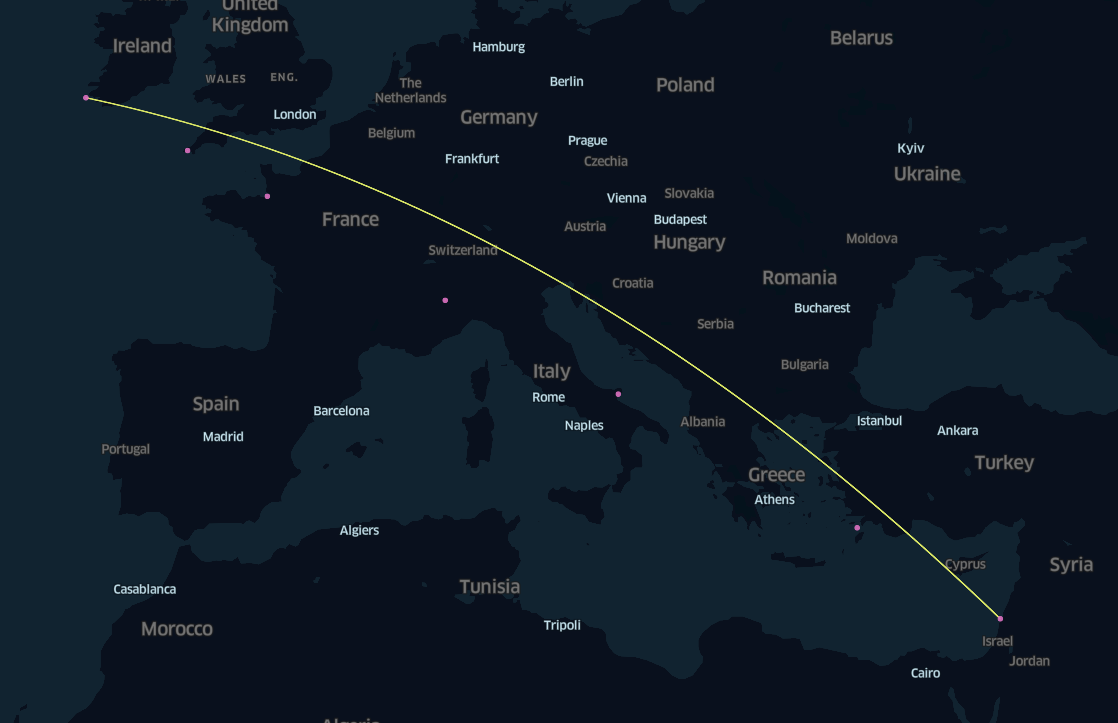

In [40]:
kepler_data = deepcopy({"cathedrals": gdf_cathedrals.__geo_interface__, "line": df_points})


if KEPLER_OUTPUT:
    kcm = KeplerConfigManager()
    config_map_2 = kcm.load_config("configs_map_2")
    
    kmap_2 = KeplerGl(
        data=kepler_data,
        height=800,
        config=config_map_2,
    )
    display(kmap_2)
else:
    display(Image("images/cathedrals_in_a_row_with_geodesic.png"))

In [41]:
if KEPLER_OUTPUT and OVERWRITE_CONFIGS:
    kcm = KeplerConfigManager()
    kcm.save_config(kmap_2, "configs_map_2")

## Distance between the cathedrals and the geodesic line connecting the first and the last one.

Visually we can see that the cathedrals are not aligned over the geodesics. Let's measure the sum of the distances between each cathedral and the geodesic. We will use the distance between the bell tower and the geodesics passing through the bell towers of the first and the last cathedrals.

### Distance between a point and a geodesic line on the sphere

Finding the distance between a point and a line is equivalent to find the projection of the point on the line itself. Using planes we can find the direction of the projection, as a vector, and then we can project it on the sphere with the function $\pi$ defined above.

Let $A$ and $B$ two points on the geodesic line, and $C$ a point on the sphere, we indicate with $\mathcal{d}_{\mathbb{S}^2}(C, \overset{\frown}{AB})$ the sought distance between $C$ and the geodesic passing through $AB$. 
Using the [cross product](https://en.wikipedia.org/wiki/Cross_product) $\times$ then we can use the following facts:

- $E = A\times B$ is the vector normal to the plane $\triangle OAB$.
- $F = C\times E$ is the vector normal to the plane $\triangle OCA$, which is also perpendicular to $\triangle OAB$ and passes through $C$.
- $G = E\times F$ is the vector belonging to the plane $\triangle OAB$, projection of $C$.

The projection of $G$ on the sphere $\pi(G)$ is the projection of $C$ over the geodesic curve $AB$, therefore the sought distance is:

$$
\mathcal{d}_{\mathbb{S}^2}(C, \overset{\frown}{AB}) = \mathcal{Hav}(C, \pi(G)) 
$$

![](images/distance_point_geodesic_line.png){#fig-distance-point-geodesic-line}


In [42]:
def distance_point_line(point: Point, line: tuple[Point, Point]) -> float:
    """A geodesic line is defined by two points on the sphere"""
    
    if len(line) != 2 or line[0] == line[1]:
        raise ValueError("Line must have two different elements")
    
    A, B = iota(np.deg2rad(line[0].lon), np.deg2rad(line[0].lat)), iota(np.deg2rad(line[1].lon), np.deg2rad(line[1].lat))
    C = iota(np.deg2rad(point.lon), np.deg2rad(point.lat))

    E = np.cross(A, B)
    F = np.cross(C, E)
    G = np.cross(E, F)

    G_theta, G_phi = pi(G[0], G[1], G[2])
    return hav(point, Point(np.rad2deg(G_theta), np.rad2deg(G_phi)))

# Sanity checks
np.testing.assert_almost_equal(2 * np.pi * R_Km/8, distance_point_line(Point(0, 45), (Point(0,0), Point(90,0))))
np.testing.assert_almost_equal(2 * np.pi * R_Km/4, distance_point_line(Point(0, 90), (Point(0,0), Point(90,0))))
np.testing.assert_almost_equal(2 * np.pi * R_Km/2, distance_point_line(Point(180, 0), (Point(0,0), Point(0,90))))
np.testing.assert_almost_equal(0, distance_point_line(Point(0, 1), (Point(0, 0), Point(0, 2))))

Now we can use the created function to compute all the distances between the geodesic and each cathedral:

In [43]:
line = (Point(gdf_cathedrals.loc[1, "longitude"], gdf_cathedrals.loc[1, "latitude"]), Point(gdf_cathedrals.loc[7, "longitude"], gdf_cathedrals.loc[7, "latitude"]))
gdf_cathedrals["dist_to_geod"] = gdf_cathedrals.apply(lambda row: distance_point_line(Point(row["longitude"], row["latitude"]), line), axis=1)
gdf_cathedrals

,name,longitude,latitude,geometry,dist_to_geod
1,Skellig Michael,-10.538483,51.772035,"POLYGON ((-10.53821 51.77219, -10.53837 51.772...",1.094214e-13
2,St Michael's Mount,-5.477813,50.116531,"POLYGON ((-5.47754 50.11673, -5.47791 50.11667...",9.303994e+01
3,Mont Saint-Michel,-1.511447,48.636038,"POLYGON ((-1.51184 48.63619, -1.51195 48.63616...",1.638178e+02
4,Sacra di San Michele,7.342842,45.098029,"POLYGON ((7.34246 45.09750, 7.34277 45.09750, ...",2.709241e+02
5,San Michele Arcangelo,15.954767,41.70777,"POLYGON ((15.95471 41.70775, 15.95485 41.70775...",2.651008e+02
6,Taxiarchi Michail,27.846123,36.548389,"POLYGON ((27.84592 36.54830, 27.84609 36.54836...",1.269761e+02
7,Stella Maris,34.96996,32.827297,"POLYGON ((34.96991 32.82768, 34.96963 32.82716...",0.000000e+00


In [44]:
print(f"Root means squared error: {np.round(np.sqrt(gdf_cathedrals['dist_to_geod'].apply(lambda x: x**2).sum() / len(gdf_cathedrals) ), 4) } Km")

Root means squared error: 167.0303 Km


## Are the cathedrals aligned on the Mercator projection?

With our experiments and measurements we saw that the cathedrals are not aligned in the spherical geometry. Visually on the same line only on the KeperlGl Mercator map projection.
As for the previous case the model for the visualisation is different than the model for estimating the distance between the line and the cathedral.

Let's create a straight line between the first and the last Cathedral.

In [45]:
df_line = gdf_cathedrals[["name","longitude", "latitude"]].loc[[1]].copy()
df_line["longitude_next"] = gdf_cathedrals.loc[7, "longitude"]
df_line["latitude_next"] = gdf_cathedrals.loc[7, "latitude"]
df_line["name"] = "single line"
df_line

,name,longitude,latitude,longitude_next,latitude_next
1,single line,-10.538483,51.772035,34.96996,32.827297


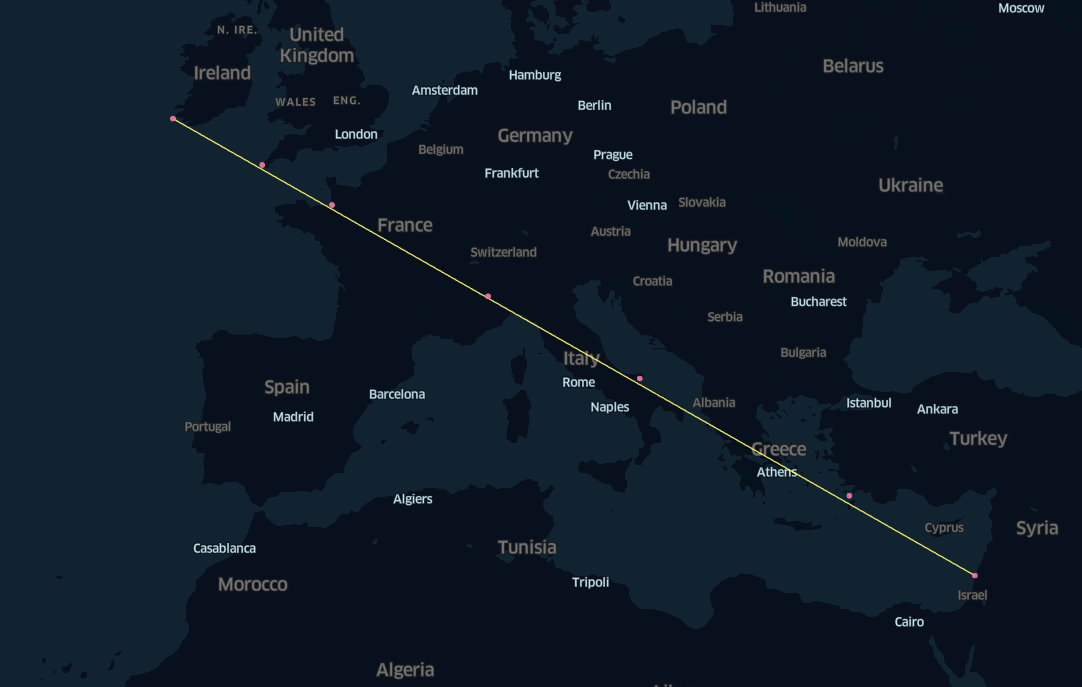

In [46]:
kepler_data = deepcopy({"cathedrals": gdf_cathedrals.__geo_interface__, "line": df_line})

if KEPLER_OUTPUT:
    kcm = KeplerConfigManager()
    config_map_3 = kcm.load_config("configs_map_3")
    
    kmap_3 = KeplerGl(
        data=kepler_data,
        height=800,
        config=config_map_3,
    )
    display(kmap_3)
else:
    display(Image("images/cathedrals_in_a_row_with_straight_line.png"))

In [47]:
if KEPLER_OUTPUT and OVERWRITE_CONFIGS:
    kcm = KeplerConfigManager()
    kcm.save_config(kmap_3, "configs_map_3")

The result with a straight line between the first and the last cathedral is more convincing than the previous one, computed with the geodesic line.

Before summing the distances between the line and the bell towers though we can think that this approach of joining the first with the last may not be the optimal one. What if we try to fit the points with linear regression?

In [48]:
gdf_cathedrals

,name,longitude,latitude,geometry,dist_to_geod
1,Skellig Michael,-10.538483,51.772035,"POLYGON ((-10.53821 51.77219, -10.53837 51.772...",1.094214e-13
2,St Michael's Mount,-5.477813,50.116531,"POLYGON ((-5.47754 50.11673, -5.47791 50.11667...",9.303994e+01
3,Mont Saint-Michel,-1.511447,48.636038,"POLYGON ((-1.51184 48.63619, -1.51195 48.63616...",1.638178e+02
4,Sacra di San Michele,7.342842,45.098029,"POLYGON ((7.34246 45.09750, 7.34277 45.09750, ...",2.709241e+02
5,San Michele Arcangelo,15.954767,41.70777,"POLYGON ((15.95471 41.70775, 15.95485 41.70775...",2.651008e+02
6,Taxiarchi Michail,27.846123,36.548389,"POLYGON ((27.84592 36.54830, 27.84609 36.54836...",1.269761e+02
7,Stella Maris,34.96996,32.827297,"POLYGON ((34.96991 32.82768, 34.96963 32.82716...",0.000000e+00


In [49]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()

x = gdf_cathedrals["longitude"].to_numpy().reshape((-1, 1))
y = gdf_cathedrals["latitude"].to_numpy()

model.fit(x, y)

m, n = model.coef_[0], model.intercept_
print(f"Regression line: y = {np.round(m, 3)} x + {np.round(n, 3)}")

a, b, c = m , -1, n
print(f"Implicit form  : {np.round(a, 3)} x {np.round(b, 3)} y + {np.round(c, 3)} = 0")


Regression line: y = -0.414 x + 47.873
Implicit form  : -0.414 x -1 y + 47.873 = 0


In [50]:
def get_y(input_x, input_m, input_n):
    """ in degrees! """
    return input_x * input_m + input_n

def get_dist_deg(input_x, input_y, input_a, input_b, input_c):
    """ in degrees! """
    return np.abs(input_a * input_x + input_b * input_y + input_c ) / np.sqrt(input_a ** 2 + input_b ** 2)

In [51]:
df_regression = gdf_cathedrals[["name", "longitude", "latitude"]].copy()
df_regression["latitude_estimated"] = get_y(df_regression["longitude"], m, n)
df_regression["latitude_estimated_next"] = df_regression["latitude_estimated"].shift(-1)
df_regression["longitude_next"] = df_regression["longitude"].shift(-1)
df_regression

,name,longitude,latitude,latitude_estimated,latitude_estimated_next,longitude_next
1,Skellig Michael,-10.538483,51.772035,52.238049,50.142038,-5.477813
2,St Michael's Mount,-5.477813,50.116531,50.142038,48.499262,-1.511447
3,Mont Saint-Michel,-1.511447,48.636038,48.499262,44.832022,7.342842
4,Sacra di San Michele,7.342842,45.098029,44.832022,41.265163,15.954767
5,San Michele Arcangelo,15.954767,41.70777,41.265163,36.340041,27.846123
6,Taxiarchi Michail,27.846123,36.548389,36.340041,33.389514,34.96996
7,Stella Maris,34.96996,32.827297,33.389514,NaN,NaN


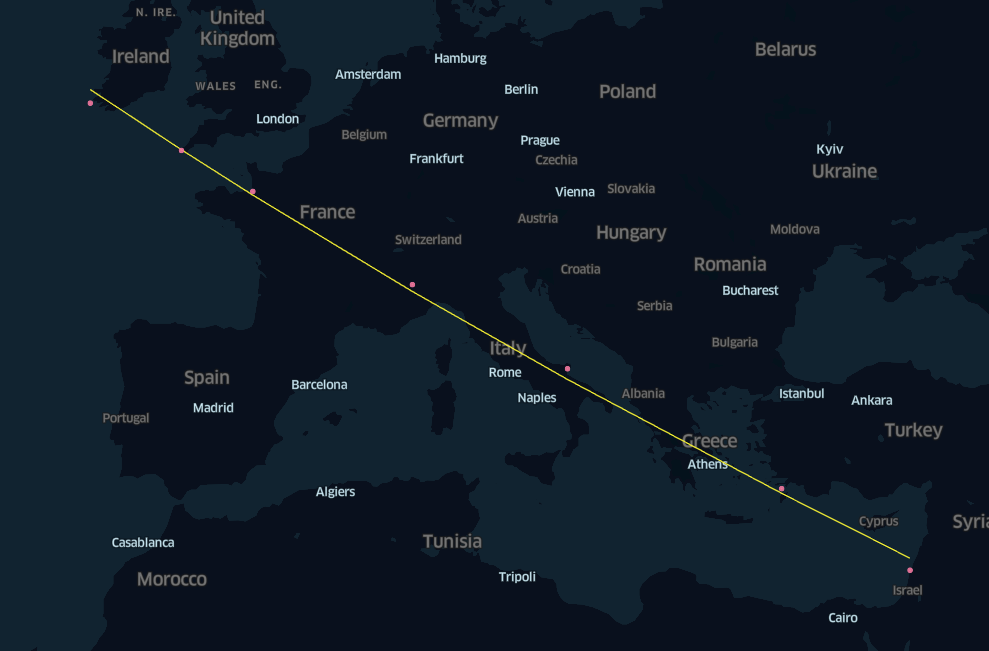

In [52]:
kepler_data = deepcopy({"cathedrals": gdf_cathedrals.__geo_interface__, "line": df_regression})

if KEPLER_OUTPUT:
    kcm = KeplerConfigManager()
    config_map_4 = kcm.load_config("configs_map_4")
    
    kmap_4 = KeplerGl(
        data=kepler_data,
        height=800,
        config=config_map_4,
    )
    display(kmap_4)
else:
    display(Image("images/cathedrals_in_a_row_with_straight_line_regression.png"))

In [53]:
if KEPLER_OUTPUT and OVERWRITE_CONFIGS:
    kcm = KeplerConfigManager()
    kcm.save_config(kmap_4, "configs_map_4")

We can see that the line computed with linear regression in degrees is closer to the rows of cathedral than it is for the geodesic. Here as well we can compute the average distance in degrees between the line and the bell towers with the function `get_dist_deg` implemented above, though this distance would not be a "real" distance in any meaningful sense.

### Unanswered question

Now we know that the cathedrals are not aligned on the geodesic. Are they "almost" aligned on the mercator projection by accident or was there a plan? 

Did the builders knew the earth was round? Or did they followed some method that is today lost, possibly based on the position of a start or a constellation, resulting in an alignment on the Mercator projection? 

Certainly 7 cathedrals are too many to be a coincidence, and more historical investigations about the past knowledge would be at this point an interesting project.

## Bloopers

In a first attempt of plotting the regression line with Kepler, we started drawing a straight line between the first and the last point, with the latitude computed via linear interpolation.

In [54]:
df_line_regression = gdf_cathedrals[["name", "longitude", "latitude"]].copy()
df_line_regression["latitude_estimated"] = get_y(df_line_regression["longitude"], m, n)
df_line_regression = df_line_regression.drop(columns=["latitude"])
df_line_regression["longitude_next"] = df_line_regression.loc[7, "longitude"]
df_line_regression["latitude_estimated_next"] = df_line_regression.loc[7, "latitude_estimated"]
df_line_regression = pd.DataFrame(df_line_regression.loc[1]).T
df_line_regression


,name,longitude,latitude_estimated,longitude_next,latitude_estimated_next
1,Skellig Michael,-10.538483,52.238049,34.96996,33.389514


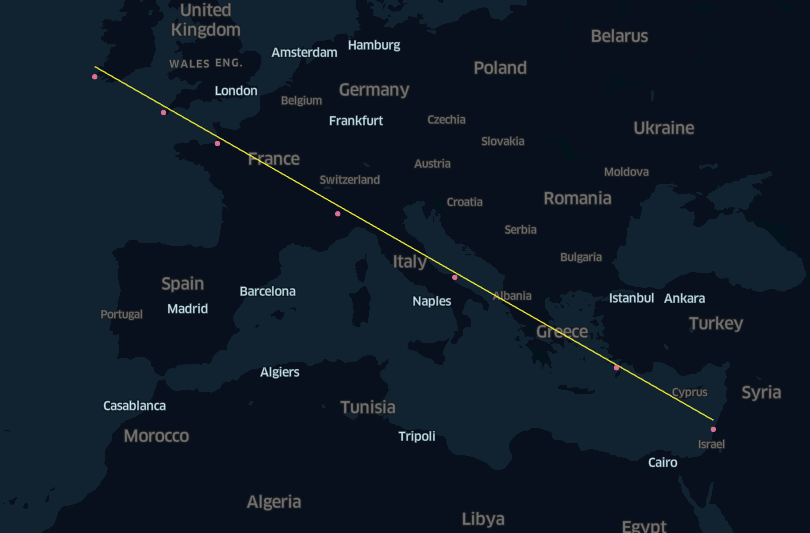

In [55]:
kepler_data = deepcopy({"cathedrals": gdf_cathedrals.__geo_interface__, "line": df_line_regression})

if KEPLER_OUTPUT:
    kcm = KeplerConfigManager()
    config_map_5 = kcm.load_config("configs_map_5")
    
    kmap_5 = KeplerGl(
        data=kepler_data,
        height=800,
        config=config_map_5,
    )
    display(kmap_5)
else:
    display(Image("images/cathedrals_in_a_row_with_straight_line_regression_wrong.png"))

In [56]:
if KEPLER_OUTPUT and OVERWRITE_CONFIGS:
    kcm = KeplerConfigManager()
    kcm.save_config(kmap_5, "configs_map_5")

Can you see what went wrong? Why are all the points below the regression line? 

## Summary

### Topics

- A dataset of cathedrals segmentations.
- Drawing a geodesic between two point.
- Distance point-to-geodesic line.
- Linear regression on the Mercator projection.
- Distance point-line on the Mercator projection.

### Questions and further experiments

- Can you draw the geodesic lines between each cathedral the the geodesic between the first and the last one?
- To compute the distance between cathedrals we considered the geolocation of the tower bell. What about using the closest wall?
- Geodesics linear regression?
- Trace the geodesic line with Vincenty's formula with the same recursive algorithm?

These and more will come soon in the next blog posts! Stay tuned!